## Analyze A/B Test Results For E-Commerce Website


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B testing is one of the common technique used for analyzing which web designs drive more traffic. Many companies use A/B testing to test feature changes, layouts and even colors to increase a metric that measures a interest from the users.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
# read data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 294478
Number of columns: 5


c. The number of unique users in the dataset.

In [5]:
print('{} unique users'.format(df.user_id.nunique()))

290584 unique users


d. The proportion of users converted.

In [6]:
print('Proportion of users converted = {:.5f}%'.format(df.converted.sum() / df.shape[0] * 100))

Proportion of users converted = 11.96592%


e. The number of times the `new_page` and `treatment` don't match.

In [7]:
num_not_match = df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | 
               ((df.landing_page == 'old_page') & (df.group != 'control'))].shape[0]
print("The number of times the new_page and treatment don't match is {}".format(num_not_match))

The number of times the new_page and treatment don't match is 3893


f. Do any of the rows have missing values?

In [8]:
print('Number of rows with missing values = {}'.format(df.isnull().any(axis = 1).sum()))

Number of rows with missing values = 0


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.


In [9]:
# remove all rows where the number of times the new_page and treatment don't match
index_for_no_match = df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | 
                        ((df.landing_page == 'old_page') & (df.group != 'control'))].index
df2 = df.drop(index = index_for_no_match)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Let's investigate the data frame after the change performed in previous step.

a. How many unique **user_id**s are in **df2**?

In [11]:
print('{} unique users'.format(df2.user_id.nunique()))

290584 unique users


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
print('The one user_id repeated in df2 is {}'.format(df2[df2.user_id.duplicated()].iloc[0, 0]))

The one user_id repeated in df2 is 773192


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# remove duplicte user_id as row values are consistent
df2 = df2.drop(index = df2[df2.user_id.duplicated()].index)

In [15]:
# verify for duplicate user ids
df2.user_id.duplicated().sum()

0

`4.` Find probabilites using **df2**

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
prob_regardless_page = (df.converted == 1).mean()
print('Probability of converting regardless of page is {:.5f}'.format(prob_regardless_page))

Probability of converting regardless of page is 0.11966


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
prob_control_group = ((df.group == 'control') & (df.converted == 1)).sum() / (df.group == 'control').sum()
print('Probability of converting given that individual is in control group is {:.5f}'.format(prob_control_group))

Probability of converting given that individual is in control group is 0.12040


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
prob_treatment_group = ((df.group == 'treatment') & (df.converted == 1)).sum() / (df.group == 'treatment').sum()
print('Probability of converting given that individual is in treatment group is {:.5f}'.format(prob_treatment_group))

Probability of converting given that individual is in treatment group is 0.11892


d. What is the probability that an individual received the new page?

In [19]:
prob_indi_recieved_page = (df.landing_page == 'new_page').mean()
print('probability that an individual received the new page is {:.5f}'.format(prob_indi_recieved_page))

probability that an individual received the new page is 0.50000


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Let me bring down my results over here so that it will be easy to interpret**
- Probability of converting regardless of page is `0.11966`.
- Probability of converting given that individual is in control group is `0.12040`.
- Probability of converting given that individual is in treatment group is `0.11892`.
- probability that an individual received the new page is `0.50000`.

From whatever evidence I have from above results, I believe that implementing new page will not increase the conversion rate. **_However there isn't sufficient imformation to conclude this for sure because the difference in probability is very less._**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \le 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = (df2.converted == 1).mean()
print('The conversion rate for p_new under the null is {:.5f}'.format(p_new))

The conversion rate for p_new under the null is 0.11960


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = (df2.converted == 1).mean()
print('The conversion rate for p_old under the null is {:.5f}'.format(p_old))

The conversion rate for p_old under the null is 0.11960


c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2.group == 'treatment'].shape[0]
print('The number of individuals in the treatment group is {}'.format(n_new))

The number of individuals in the treatment group is 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2.group == 'control'].shape[0]
print('The number of individuals in the treatment group is {}'.format(n_old))

The number of individuals in the treatment group is 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [46]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [47]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [48]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()  
obs_diff

0.00014924751691716698

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [49]:
# simulate for 10000 times
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [50]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

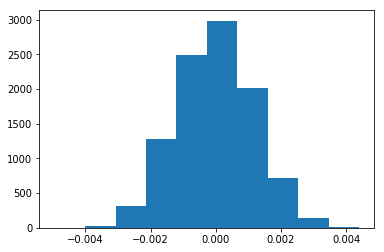

In [112]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [88]:
# calculate actual observed difference
p_diff_orig = df[df['landing_page'] == 'new_page']['converted'].mean() -  df[df['landing_page'] == 'old_page']['converted'].mean()

In [89]:
(p_diffs > p_diff_orig).mean()

0.91239999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- The value that is computed in step j is called as `p-value` which is defined as **_if null hypothesis is true, the probability of obtaining the observed statistic or one or more extreme in favour of the alternative hypothesis._**

- The `p-value` is dependent on alternative hypothesis. Based on the alternative hypothesis we shade the region and find the area under the shaded region to obtain p-value.

- In my test the `p-value` is `0.9124` which indicates that I failed to reject the null at a type 1 error of `5%`. I can say that the new page is equal to the old page in terms of conversion rate at this null hypothesised value. However we cannot say for sure whether the new page is worse than old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [53]:
import statsmodels.api as sm

convert_old = ((df.converted == 1) & (df.landing_page == 'old_page')).sum()
convert_new = ((df.converted == 1) & (df.landing_page == 'new_page')).sum()
n_old = (df.landing_page == 'old_page').sum()
n_new = (df.landing_page == 'new_page').sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [54]:
# perform z_test
z_score, p_value = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print('p_value: {}'.format(p_value))
print('z_score: {}'.format(z_score))

p_value: 0.9143962454534289
z_score: 1.3683341399998907


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- We should note that in the earlier setup the hypotheses where `one sided` while in the `z_test` the hypotheses are `two sided`. 
- The `p_value` of `0.914` still suggests that I failed to reject the null at the type 1 error rate of `5%`. That is the new page is same as the old page in terms of conversion rate.
- While the `z_score` of `1.3683` tell us how far from mean of distribution a point lies and this value is used for calculating the `p_value`.
- Finally, these values agree with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

- **Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [55]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [56]:
df2['intercept'] = 1
df2['ab_page'] = df2.group.map({'treatment': 1, 'control': 0})
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [57]:
# perform logistic regression on data
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [58]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-14 13:03 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

- The `p-value` associated with `ab_page` is `0.1899` and it is different from what we have in part 2 because of the following reason:
  - The setup for hypothesis test in part 2 is one tailed that is
$$H_0: p_{new} - p_{old} \le 0$$
$$H_1: p_{new} - p_{old} > 0$$
  - While the setup for hypothesis considered by regression model is two tailed that is
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \not= 0$$
- So inorder to get the same `p-value` we have do the following:
>$pvalue_{onetailed} = 1 - \frac{0.1899}{2} = 0.91$
 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- It is good idea to consider other factors to add in regression model to understand how other factors would effect the results. There will be number of factors that correlate to the response variable that your predicting and hence considering them can yeild different results.
- But considering mutliple factors can bring in the following potential problems:
  - Multicollinearity
  - Non-linearity of the response-predictor relationships
  - Correlation of error terms
  - Outliers

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. I will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [59]:
# read countries file
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [72]:
# join df2 dataframe with df_country dataframe
df_new = df2.join(df_country.set_index('user_id'), on = 'user_id')

In [73]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [74]:
df_new.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [75]:
# 0, 1 encoding for country attribute
df_new[['US', 'CA', 'UK']] = pd.get_dummies(df_new['country'])

In [76]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [81]:
# conversion rate for US
us_conv = ((df_new.country == 'US') & (df_new.converted == 1)).sum() / (df_new.country == 'US').sum()
print('The conversion rate when page is viewed from US is {}'.format(us_conv))

The conversion rate when page is viewed from US is 0.1195468006423762


In [113]:
# conversion rate for CA
ca_conv = ((df_new.country == 'CA') & (df_new.converted == 1)).sum() / (df_new.country == 'CA').sum()
print('The conversion rate when page is viewed from CA is {}'.format(ca_conv))

The conversion rate when page is viewed from CA is 0.11531829781364232


In [114]:
# conversion rate for UK
uk_conv = ((df_new.country == 'UK') & (df_new.converted == 1)).sum() / (df_new.country == 'UK').sum()
print('The conversion rate when page is viewed from UK is {}'.format(uk_conv))

The conversion rate when page is viewed from UK is 0.12059448568984076


- It seems like country has impact on conversion rate as it varies from country to country.
- Highest being for `UK` with approximately `12%` and least being for `US` with approximately `11.9%`.

h. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model. 

In [84]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [85]:
# perform logistic regression on data with countries
logi_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'CA']])
results = logi_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-14 13:42 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
CA            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [87]:
# interpreting logistic regression model coefficients 
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

In [100]:
# find end and start of test
df_new.timestamp.max(), df_new.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [110]:
from datetime import datetime

# calculate test duration
fmt = '%Y-%m-%d %H:%M:%S'
tstamp1 = datetime.strptime('2017-01-24 13:41:54', fmt)
tstamp2 = datetime.strptime('2017-01-02 13:42:05', fmt)

td = tstamp1 - tstamp2
print('The test is conducted for just over {} days'.format(td.days))

The test is conducted for just over 21 days


### Summary & Conclusions
- If an individual is from UK, they are `1.0416` times more likely to be `converted` than if they are from US, holding all other variables constant.
- If an individual is from CA, they are `1.009` times more likely to be `converted` than if they are from UK, holding all other variables constant.
- It is observed that the difference in conversion rates for different countries is small which may be not practically significant.

**Based on p_values we again say that we failed to reject the null at a type 1 error rate of `5%`. This implies that the new page is same as the old page in terms of conversion rate.**

Finally, I would suggest the company to stick with the old page or else conduct the test for longer time to better understand whether or not to implement the new page(from this data it seems like the test is conducted for just over 21 days which may not be sufficient to better understand the results).